In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns

### A first glance at the data

In [6]:
faithful = pd.read_csv('../data/old_faithful.csv')

In [4]:
faithful.describe()

,eruptions,waiting
count,272.000000,272.000000
mean,3.487783,70.897059
std,1.141371,13.594974
min,1.600000,43.000000
25%,2.162750,58.000000
50%,4.000000,76.000000
75%,4.454250,82.000000
max,5.100000,96.000000


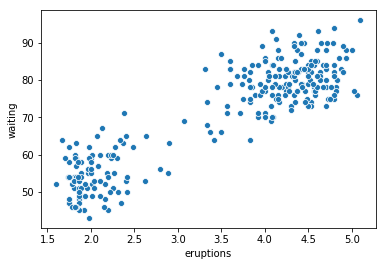

In [520]:
sns.scatterplot(x='eruptions', y='waiting', data=faithful)

Two distinct clusters are visible

## Clustering algorithm definitions & applications

### Starting with the basics: k-means and k-means++

In [362]:
def expectation(data, mu):
    def compute_squared_distances(mean):
        return np.square(data - mean).sum(axis=1)
    return np.apply_along_axis(compute_squared_distances, 1, mu).argmin(axis=0)

In [363]:
def maximisation(data, assignments, k):
    def compute_mean(j):
        return data[assignments == j].mean(axis=0)
    return np.apply_along_axis(compute_mean, 0, [list(range(k))]).transpose()

In [364]:
def compute_squared_distances(data, mean):
    return np.square(data - mean).sum(axis=1)

In [365]:
def pp_init(data, k):
    data_shape = data.shape
    include = np.ones(data_shape[0], np.bool)
    mu = np.zeros((k, data_shape[1]))
    idx = np.random.randint(0, data_shape[0], 1)
    include[idx] = False
    mu[0] = data[idx].copy()
    indices = np.arange(data_shape[0])
    for i in range(1, k):
        assignments = expectation(data, mu[:i])
        assigned_means = data.copy()
        for j in range(data_shape[0]):
            assigned_means[j] = mu[assignments[j]]
        dist_sqrs = compute_squared_distances(data, assigned_means)[include]
        idx = np.random.choice(indices[include], p = dist_sqrs / dist_sqrs.sum())
        include[idx] = False
        mu[i] = data[idx].copy()
    return mu

In [366]:
def init_mu(mu, data, k):
    data_shape = data.shape
    if isinstance(mu, np.ndarray) or isinstance(mu, pd.Series):
        mu_shape = mu.shape
        if mu_shape[1] != data_shape[1]:
            raise ValueError('Data element and mean dimensions differ')
        if mu_shape[0] != k:
            raise ValueError('Number of means provided not equal to k')
        return mu.copy()
    elif mu == 'random':
        return data[np.random.randint(0, data_shape[0], k)].copy()
    elif mu == '++':
        return pp_init(data, k)
    else:
        raise ValueError("Invalid value for mu. Accepted values: 'random', '++', or array-like")

In [367]:
def kmeans(data, k, mu='random', tol=1e-6):
    data_cp = np.array(data, copy=True)
    mu_cp = init_mu(mu, data_cp, k)
    assignments = expectation(data_cp, mu_cp)
    mu_next = maximisation(data_cp, assignments, k)
    while np.linalg.norm(mu_next - mu_cp) >= tol:
        mu_cp = mu_next
        assignments = expectation(data_cp, mu_cp)
        mu_next = maximisation(data_cp, assignments, k)
    return (mu_next, assignments)

#### k-means

In [485]:
mu, assignments = kmeans(faithful, 2)

In [486]:
mu

array([[ 4.29793023, 80.28488372],
       [ 2.09433   , 54.75      ]])

_Remark_: The chosen means coincide well with what visual inspection suggests. Things are unlikely to go so smoothly with messier data.

#### k-means++

In [460]:
mu, assignments = kmeans(faithful, 2, mu='++')

In [461]:
mu

array([[ 4.29793023, 80.28488372],
       [ 2.09433   , 54.75      ]])

_Remark_: The solution is identical, unsurprisingly (I'd expect it to be at least very similar in this case). Not much to see here.

### k-medians

#### TODO: DEBUG / figure out medoid=True support!!!

In [7]:
def kmedians_maximisation(data, assignments, k, medoid=False):
    def compute_median(j):
        return np.median(data[assignments == j], axis=0)
    # Pretty sure the element closest to the median minimises the sum of absolute Euclidean distances,
    # though a proper proof would be more involved than I can handle right now
    # In fact, why doesn't any reference state so explicitly when harping on about PAM being O(n^2) in general???
    def compute_medoid(j):
        cluster = data[assignments == j]
        return cluster[((cluster - compute_median(j)) ** 2).argmin()]
    if medoid:
        return np.apply_along_axis(compute_medoid, 0, [list(range(k))]).transpose()
    return np.apply_along_axis(compute_median, 0, [list(range(k))]).transpose()

In [522]:
def kmedians(data, k, mu='random', medoid=False, tol=1e-6):
    data_cp = np.array(data, copy=True)
    mu_cp = init_mu(mu, data_cp, k)
    assignments = expectation(data_cp, mu_cp)
    mu_next = kmedians_maximisation(data_cp, assignments, k, medoid)
    while np.linalg.norm(mu_next - mu_cp) >= tol:
        mu_cp = mu_next
        assignments = expectation(data_cp, mu_cp)
        mu_next = kmedians_maximisation(data_cp, assignments, k, medoid)
        print(mu_next)
    return (mu_next, assignments)

In [462]:
mu, assignments = kmedians(faithful, 2)

In [463]:
mu

array([[ 1.983, 54.   ],
       [ 4.35 , 80.   ]])

_Remark_: The result is close but not equal to that from kmeans(++), which again makes sense

### k-medoids / partitioning around medoids (PAM)

In [376]:
def compute_cost(data, assignments, mu):
    closest_means = np.zeros(data.shape)
    for i in range(len(closest_means)):
        closest_means[i] = mu[assignments[i]]
    return compute_squared_distances(data, closest_means).sum()

In [377]:
def k_pam(data, k, mu='random', tol=1e-6):
    data_shape = data.shape
    data_cp = np.array(data, copy=True)
    mu_cp = init_mu(mu, data_cp, k)
    assignments = expectation(data, mu_cp)
    prev_cost = np.inf
    note_mu, note_assignments, cost = mu_cp, assignments, compute_cost(data_cp, assignments, mu_cp)
    while cost < prev_cost:
        mu_cp, assignments, prev_cost = note_mu, note_assignments, cost
        not_centroid = np.ones(data_shape[0], dtype=np.bool)
        for j in range(data_shape[0]):
            not_centroid[j] = not((data_cp[j] == mu_cp).all(axis=1).any())
        for i in range(k):
            for datum in data_cp[not_centroid]:
                tmp_mu = mu_cp.copy()
                tmp_mu[i] = datum
                tmp_assignments = expectation(data_cp, tmp_mu)
                tmp_cost = compute_cost(data_cp, tmp_assignments, tmp_mu)
                if tmp_cost < cost:
                    note_mu, note_assignments, cost = tmp_mu, tmp_assignments, tmp_cost
    return (mu_cp, assignments)

In [487]:
mu, assignments = k_pam(faithful, 2)

In [488]:
mu

array([[ 2.183, 55.   ],
       [ 4.35 , 80.   ]])

In [503]:
mu, assignments = k_pam(faithful, 2, mu='++')

In [504]:
mu

array([[ 2.183, 55.   ],
       [ 4.35 , 80.   ]])

_Remark_: 1 centroid is identical to that chosen by k-medians, while the other is different though with a similar (marginally smaller) discrepancy from that chosen by k-means.

## Selecting an optimal k and/or method
(even though in this case k is obviously 2)

In [468]:
def get_sorted_data(data_init, assnmts_init):
    data = data_init.copy()
    data['cluster'] = assignments
    data.sort_values(by='cluster', axis=0, inplace=True)
    return (data[data.columns[:-1]], data.cluster)

In [469]:
def get_cross_distances(data):
    cross_vals = np.repeat(data.values[np.newaxis], len(data), axis=0)
    cross_diffs = cross_vals - np.repeat(data.values[:, np.newaxis, :], len(data), axis=1)
    cross_distances = pd.DataFrame(np.sqrt((cross_diffs ** 2).sum(axis=2)))
    return cross_distances

In [470]:
def adjust_self_distances(obs_mean_distances, cluster_sizes):
    cluster_sizes = obs_mean_distances.apply(lambda obs: cluster_sizes[obs.cluster], axis=1)
    self_dist = obs_mean_distances.apply(lambda obs: obs[int(obs.cluster)], axis=1)
    adj = cluster_sizes / (cluster_sizes - 1)
    return self_dist * adj

In [471]:
def get_silhouettes_from_distances(cross_distances, assignments):
    cross_distances['cluster'] = assignments.reset_index(drop=True).astype(int)
    cluster_sizes = cross_distances.cluster.value_counts(sort=False)
    cluster_cumsum = cluster_sizes.cumsum()
    cluster_mean_distances = cross_distances.groupby('cluster').mean()
    obs_mean_distances = cluster_mean_distances.T
    obs_mean_distances['cluster'] = assignments.reset_index(drop=True).astype(int)
    obs_mean_distances['self_dist'] = adjust_self_distances(obs_mean_distances, cluster_sizes)
    obs_mean_distances['other_clusters'] = obs_mean_distances.cluster.apply(lambda c: cluster_sizes.index.difference([c]))
    obs_mean_distances['min_other_dists'] = obs_mean_distances.apply(lambda obs: obs[obs.other_clusters], axis=1).min(axis=1)
    max_dist = obs_mean_distances[['self_dist', 'min_other_dists']].max(axis=1)
    obs_mean_distances['silhouette'] = (obs_mean_distances.min_other_dists - obs_mean_distances.self_dist) / max_dist
    return obs_mean_distances.silhouette

In [480]:
def get_silhouettes(data_init, assnmts_init):
    data, assignments = get_sorted_data(data_init, assnmts_init)
    cross_distances = get_cross_distances(data)
    silhouettes = get_silhouettes_from_distances(cross_distances, assignments)
    silhouettes.index = data.index
    return silhouettes.reindex(data_init.index)

In [508]:
def get_silhouette_coefficient(data, assignments):
    return get_silhouettes(data, assignments).mean()

### Vary k using k-means++
Skip method selection because differences in clustering quality (according to metrics e.g. the silhouette coefficient) seem likely marginal in this case.

In [511]:
scores = [0] * 10
for k in range(1, 10):
    mu, assignments = kmeans(faithful, k)
    scores[k] = get_silhouette_coefficient(faithful, assignments)

In [516]:
scores

[0,
 nan,
 0.7240548519958575,
 0.5836176227759594,
 0.546831400306024,
 0.5481460043306782,
 0.5129618420243028,
 0.529500610146896,
 0.49058460059988773,
 0.5223351735327652]

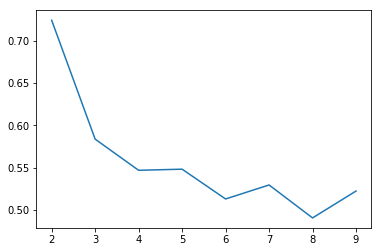

In [515]:
plt.plot(range(2, 10), scores[2:10])

_Remarks_: Unsurprisingly (in this case), the silhouette coefficient decreases as k increases, with the highest value (by far) at k=2.